<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/02_nice_with_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [322]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [323]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [324]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)


    def forward(self, x):
        x = x.view(len(x), -1,).to(torch.float32)
        return self.f(x)

    def coupling_layer(self, x, m, flow, forward=True):
        x = x.clone()

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a
        return z


    def f(self, x):
        z = x

        for flow, model in enumerate(self.m, start=0):
            z = self.coupling_layer(z, model, flow, forward=True)

        z = z / torch.exp(self.s)
        log_det_j = torch.sum(self.s)

        return z, log_det_j

    def f_inv(self, z):
        x = z * torch.exp(self.s)

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            x = self.coupling_layer(x, model, flow,forward=False)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) - log_det_j).mean()
        return loss

In [325]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    stratify=digits.target,
                                                    test_size=0.25,
                                                   random_state=42)

train_data = Data(X_train)


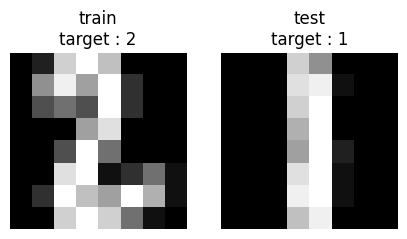

In [326]:
random_number = torch.randint(0,9,[1]).item()
image_train, category_train = X_train[random_number], y_train[random_number]
image_test, category_test = X_test[random_number], y_test[random_number]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((8,8)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((8,8)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [327]:
data_dim = 8*8

prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=512, num_flows=10)

train_loader = DataLoader(train_data, batch_size=250, shuffle=True)


In [328]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  304875.15408325195
Epoch :  2   -----------> Loss :  809.9533640543619
Epoch :  3   -----------> Loss :  477.0824228922526
Epoch :  4   -----------> Loss :  413.1043192545573
Epoch :  5   -----------> Loss :  384.2955678304036
Epoch :  6   -----------> Loss :  370.15020751953125
Epoch :  7   -----------> Loss :  349.61875915527344
Epoch :  8   -----------> Loss :  334.1374104817708
Epoch :  9   -----------> Loss :  324.49818420410156
Epoch :  10   -----------> Loss :  316.84901428222656
Epoch :  11   -----------> Loss :  299.21881103515625
Epoch :  12   -----------> Loss :  320.09405008951825
Epoch :  13   -----------> Loss :  321.6381429036458
Epoch :  14   -----------> Loss :  295.31541951497394
Epoch :  15   -----------> Loss :  280.84820556640625
Epoch :  16   -----------> Loss :  271.9108072916667
Epoch :  17   -----------> Loss :  262.4658686319987
Epoch :  18   -----------> Loss :  255.71523793538412
Epoch :  19   -----------> Loss :  247.492706

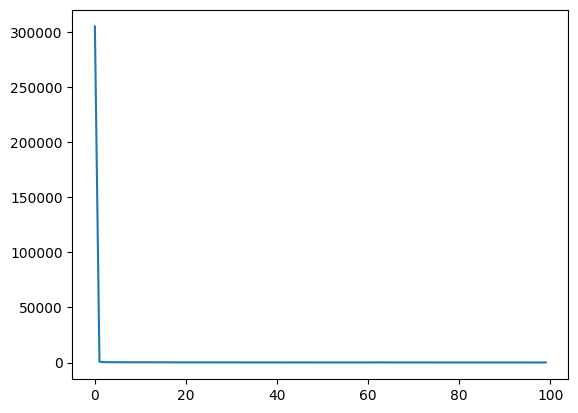

In [329]:
plt.plot(COST)

In [330]:
test = prior.sample((50,))
test

tensor([[ 0.2507,  1.1792, -0.3012,  ..., -0.1789, -0.5580,  1.5503],
        [ 0.2264, -0.3725, -0.1210,  ..., -0.2092,  0.7089,  1.3768],
        [-0.8384,  1.3377,  1.1958,  ..., -2.5913, -0.9310, -0.5243],
        ...,
        [-0.1407, -0.9377, -1.5993,  ..., -0.1129, -0.9301, -0.3378],
        [ 0.1643, -1.0266, -1.6477,  ..., -0.1154,  1.6028, -0.1695],
        [-0.6822,  1.1528, -1.1176,  ...,  0.1766, -1.5237, -0.1016]])

In [331]:
sonuc = model.f_inv(test)
sonuc

tensor([[ 3.2380e-01,  2.7793e+00,  6.6324e+00,  ...,  1.1408e+01,
          7.5585e+00,  5.9619e+00],
        [-2.6315e-02, -3.4816e-01,  9.8491e+00,  ...,  7.1232e+00,
          3.9885e+00,  2.0552e+00],
        [-1.5031e+00,  2.0765e+00,  7.5643e+00,  ...,  2.5742e+01,
          8.8374e+00,  8.6367e-01],
        ...,
        [-2.1626e-01, -4.6601e-01, -4.6015e-01,  ...,  1.0216e+01,
          2.2189e+00, -1.2361e+00],
        [ 1.8537e-02, -2.1385e+00, -9.4818e-02,  ...,  1.4529e+01,
          5.3272e+00,  6.4732e-01],
        [-9.3672e-01,  3.2784e+00,  1.2464e+01,  ..., -1.4421e+00,
         -1.4703e+00, -9.0803e-01]], grad_fn=<CopySlices>)

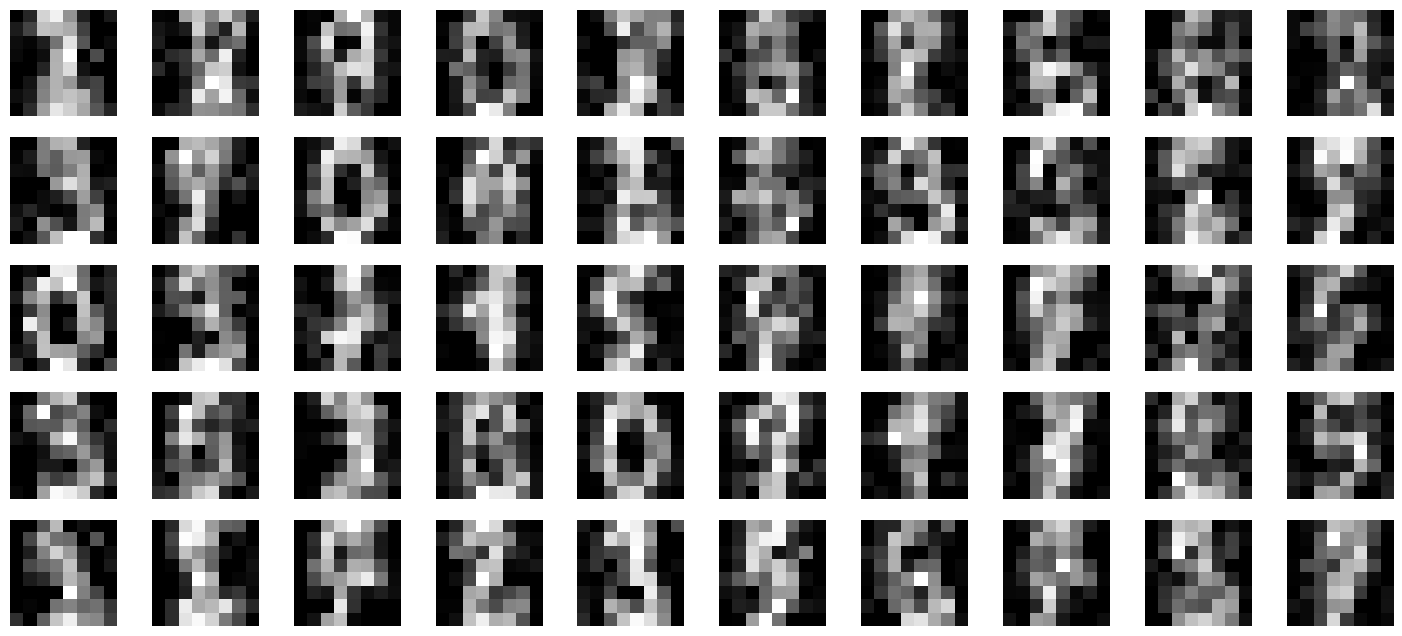

In [332]:
test = prior.sample((50,))
sonuc = model.f_inv(test)

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8))

for i in range(0,10):

    axs[0, i].imshow(torch.nn.ReLU()(sonuc[i]).detach().numpy().reshape((8,8)), cmap='gray')
    axs[1, i].imshow(torch.nn.ReLU()(sonuc[10+i]).detach().numpy().reshape((8,8)), cmap='gray')
    axs[2, i].imshow(torch.nn.ReLU()(sonuc[20+i]).detach().numpy().reshape((8,8)), cmap='gray')
    axs[3, i].imshow(torch.nn.ReLU()(sonuc[30+i]).detach().numpy().reshape((8,8)), cmap='gray')
    axs[4, i].imshow(torch.nn.ReLU()(sonuc[40+i]).detach().numpy().reshape((8,8)), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')
    axs[3, i].axis('off')
    axs[4, i].axis('off')
fig.show()